# Piscines olympiques !

In [6]:
from oggm import utils
import geopandas as gpd
from oggm import cfg
from oggm import tasks, utils, workflow, graphics, DEFAULT_BASE_URL, global_task
import xarray as xr
import matplotlib.pyplot as plt
from oggm.global_tasks import compile_fixed_geometry_mass_balance
import pandas as pd

from oggm.shop import gcm_climate

In [7]:
def get_volumes_by_scenario(glacier_name) : 
    # Initialisation du glacier_directory
    cfg.initialize(logging_level='WARNING')
    cfg.PATHS['working_dir'] = utils.gettempdir('OGGM_gcm_run', reset=True)
    rgi_ids = [glacier_name]
    gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=5, prepro_base_url=DEFAULT_BASE_URL)

    # Download and process GCM data from ISIMIP3b (bias-corrected CMIP6)
    # C'est déjà calculé sur leurs serveurs (ils ont 3 scénarios SSP de pêts) donc on les télécharge
    member = 'mri-esm2-0_r1i1p1f1' 

    for ssp in ['ssp126', 'ssp370','ssp585']:
        # bias correct them
        workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, gdirs, 
                                    ssp = ssp,
                                    # gcm member -> you can choose another one
                                    member=member,
                                    # recognize the climate file for later
                                    output_filesuffix=f'_ISIMIP3b_{member}_{ssp}'
                                    );

    # Si on veut des infos sur le climat: 
    #print(gdirs[0].get_climate_info())

    # On lance les calculs de projection dans le futur pour chacun des 3 scénarios SSP
    for ssp in ['ssp126', 'ssp370', 'ssp585']:
        rid = f'_ISIMIP3b_{member}_{ssp}'
        workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                                    climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                    climate_input_filesuffix=rid,  # use the chosen scenario
                                    init_model_filesuffix='_spinup_historical',  # this is important! Start from 2020 glacier
                                    output_filesuffix=rid,  # recognize the run for later
                                    );
    
    # On récupère les données de volume pour chaque scénario
    # On plot les volumes pour chaque scénario
    color_dict={'ssp126':'blue', 'ssp370':'orange', 'ssp585':'red'}
    scenarios = []
    for ssp in ['ssp126','ssp370', 'ssp585']:
        rid = f'_ISIMIP3b_{member}_{ssp}'
        # Compile the output into one file
        ds = utils.compile_run_output(gdirs, input_filesuffix=rid)
        scenarios.append(ds)
        print(ds)
        # Plot it
        ds.isel(rgi_id=0).volume.plot(label=ssp, c=color_dict[ssp]);
    plt.legend();
    return scenarios

In [8]:
glacier_name = 'RGI60-11.03643'

2024-05-03 11:34:49: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-05-03 11:34:49: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-05-03 11:34:49: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-05-03 11:34:51: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2024-05-03 11:34:51: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-05-03 11:34:53: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-05-03 11:34:55: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-05-03 11:34:56: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-05-03 11:34:57: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-05-03 11:34:58: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-05-03 11:34:58: oggm.workflow: Ex

<xarray.Dataset>
Dimensions:         (time: 82, rgi_id: 1)
Coordinates:
  * time            (time) float64 2.02e+03 2.021e+03 ... 2.1e+03 2.101e+03
  * rgi_id          (rgi_id) <U14 'RGI60-11.03643'
    hydro_year      (time) int64 2020 2021 2022 2023 ... 2098 2099 2100 2101
    hydro_month     (time) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4 4
    calendar_year   (time) int64 2020 2021 2022 2023 ... 2098 2099 2100 2101
    calendar_month  (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
Data variables:
    volume          (time, rgi_id) float64 1.723e+09 1.71e+09 ... 8.762e+08
    volume_bsl      (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    volume_bwl      (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    area            (time, rgi_id) float64 2.287e+07 2.282e+07 ... 1.471e+07
    length          (time, rgi_id) float64 9.322e+03 9.322e+03 ... 2.844e+03
    calving         (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  

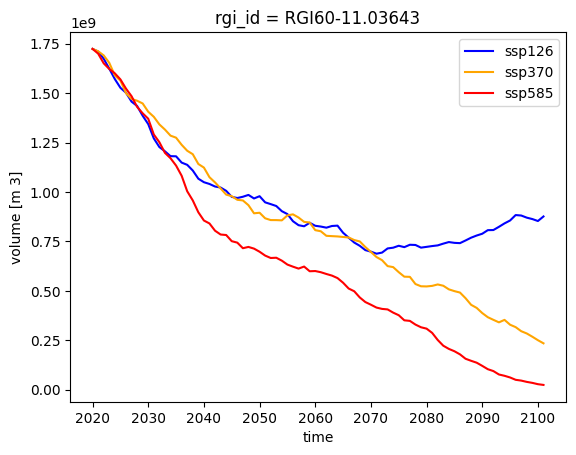

In [9]:
volumes_futurs = get_volumes_by_scenario(glacier_name)

In [10]:
volumes_futurs[0]

<xarray.Dataset>
Dimensions:         (time: 82, rgi_id: 1)
Coordinates:
  * time            (time) float64 2.02e+03 2.021e+03 ... 2.1e+03 2.101e+03
  * rgi_id          (rgi_id) <U14 'RGI60-11.03643'
    hydro_year      (time) int64 2020 2021 2022 2023 ... 2098 2099 2100 2101
    hydro_month     (time) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4 4
    calendar_year   (time) int64 2020 2021 2022 2023 ... 2098 2099 2100 2101
    calendar_month  (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
Data variables:
    volume          (time, rgi_id) float64 1.723e+09 1.71e+09 ... 8.762e+08
    volume_bsl      (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    volume_bwl      (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    area            (time, rgi_id) float64 2.287e+07 2.282e+07 ... 1.471e+07
    length          (time, rgi_id) float64 9.322e+03 9.322e+03 ... 2.844e+03
    calving         (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    calving_rate    (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    water_level     (rgi_id) float64 0.0
    glen_a          (rgi_id) float64 6.078e-24
    fs              (rgi_id) float64 0.0
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.1
    calendar:       365-day no leap
    creation_date:  2024-05-03 09:34:58

In [11]:
volume_piscine_olympique = 2500

In [45]:
volumes_futurs[0].volume.data[1]-volumes_futurs[0].volume.data[0]

array([-13168519.21511149])

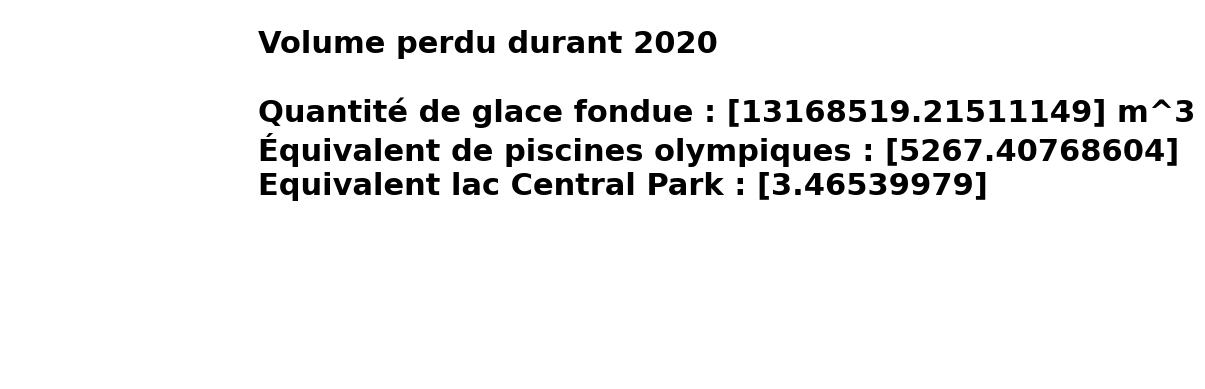

In [65]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np

# Données de quantité de glace fondue en m^3 pour chaque année
annees = volumes_futurs[0].calendar_year 
glace_presente = volumes_futurs[0].volume.values


glace_fondue = []
for i in range(1, len(glace_presente)):
    glace_fondue_an = glace_presente[i-1] - glace_presente[i]
    glace_fondue.append(glace_fondue_an)

glace_fondue = np.array(glace_fondue)
volume_piscine_olympique = 2500
volume_lac_central_park = 3.8e6

# Convertir la quantité de glace fondue en équivalent de piscines olympiques
piscines_olympiques = glace_fondue / volume_piscine_olympique 
lacs_annecy = glace_fondue / volume_lac_central_park


font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

fig, ax = plt.subplots()
plt.axis('off')


text = ax.text(0.5, 0.5, 'Texte super beau !')


def update(frame):
    text.set_text(f"Volume perdu durant {annees[frame].values}\n\nQuantité de glace fondue : {glace_fondue[frame]} m^3\nÉquivalent de piscines olympiques : {piscines_olympiques[frame]}\nEquivalent lac Central Park : {lacs_annecy[frame]}")
    return text,

# Créer l'animation
ani = FuncAnimation(fig, update, frames=len(glace_fondue), interval=100)

# Afficher l'animation dans Jupyter Notebook
HTML(ani.to_jshtml())

# Générer le code HTML de l'animation
animation_html = ani.to_jshtml();

# Écrire le code HTML dans un fichier
with open("comparaisons_volumes.html", "w") as html_file:
    html_file.write(animation_html);

In [25]:
annees[0].calendar_year.values

array(2020)